In [1]:
# Cell 1 — Imports + small sanity checks 
import os
import numpy as np
import tensorflow as tf

print("TensorFlow:", tf.__version__)

# Dataset is in the same folder as thE notebook:
DATASET_DIR = "dataset"
TRAIN_DIR = os.path.join(DATASET_DIR, "train")
VAL_DIR   = os.path.join(DATASET_DIR, "validation")

# Quick check that folders exist
print("Train dir exists:", os.path.isdir(TRAIN_DIR))
print("Val dir exists:", os.path.isdir(VAL_DIR))

# See class folders
print("Train classes:", os.listdir(TRAIN_DIR))
print("Val classes:", os.listdir(VAL_DIR))

TensorFlow: 2.20.0
Train dir exists: True
Val dir exists: True
Train classes: ['basketball', 'concert', 'stadium']
Val classes: ['basketball', 'concert', 'stadium']


In [2]:
# Cell 2 — Basic config (image size, batch size, and a little reproducibility)
IMG_SIZE = (224, 224)  
BATCH_SIZE = 16        
SEED = 42

# Make results more repeatable
tf.random.set_seed(SEED)
np.random.seed(SEED)

In [3]:
# Cell 3 — A helper: build train/val generators for a specific Keras Application model
from tensorflow.keras.preprocessing.image import ImageDataGenerator

def make_generators(preprocess_fn):
    """
    Creates ImageDataGenerator loaders with augmentation for training,
    and only preprocessing for validation.
    preprocess_fn is model-specific (e.g., mobilenet_v2.preprocess_input).
    """
    # Training: add augmentations to fight overfitting 
    train_datagen = ImageDataGenerator(
        preprocessing_function=preprocess_fn,
        rotation_range=15,
        width_shift_range=0.10,
        height_shift_range=0.10,
        zoom_range=0.15,
        horizontal_flip=True
    )

    # Validation: no augmentation, just preprocessing
    val_datagen = ImageDataGenerator(
        preprocessing_function=preprocess_fn
    )

    train_gen = train_datagen.flow_from_directory(
        TRAIN_DIR,
        target_size=IMG_SIZE,
        batch_size=BATCH_SIZE,
        class_mode="categorical",  # because we’ll use softmax with 3 classes
        shuffle=True,
        seed=SEED
    )

    val_gen = val_datagen.flow_from_directory(
        VAL_DIR,
        target_size=IMG_SIZE,
        batch_size=BATCH_SIZE,
        class_mode="categorical",
        shuffle=False
    )

    return train_gen, val_gen

In [4]:
# Cell 4 — A helper: build a transfer learning model (freeze base + add a small head)
from tensorflow.keras import layers, models

def build_tl_model(base_model, num_classes):
    """
    base_model: a tf.keras.applications model with include_top=False
    We'll freeze it, add a simple classification head, and compile.
    """
    base_model.trainable = False  # feature extractor mode 

    inputs = layers.Input(shape=(IMG_SIZE[0], IMG_SIZE[1], 3))

    # Preprocessing is already done in ImageDataGenerator,
    # so we feed inputs directly to the base model.
    x = base_model(inputs, training=False)

    # Head: keeping it small to reduce overfitting
    x = layers.Dropout(0.2)(x)
    outputs = layers.Dense(num_classes, activation="softmax")(x)

    model = models.Model(inputs, outputs)

    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
        loss="categorical_crossentropy",
        metrics=["accuracy"]
    )
    return model

In [5]:
# Cell 5 — Picking the 3 Keras Applications models 
from tensorflow.keras.applications import MobileNetV2, ResNet50, VGG16
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input as mobilenet_preprocess
from tensorflow.keras.applications.resnet50 import preprocess_input as resnet_preprocess
from tensorflow.keras.applications.vgg16 import preprocess_input as vgg_preprocess

MODEL_SPECS = [
    {
        "name": "MobileNetV2",
        "builder": lambda: MobileNetV2(weights="imagenet", include_top=False, pooling="avg", input_shape=(224,224,3)),
        "preprocess": mobilenet_preprocess
    },
    {
        "name": "ResNet50",
        "builder": lambda: ResNet50(weights="imagenet", include_top=False, pooling="avg", input_shape=(224,224,3)),
        "preprocess": resnet_preprocess
    },
    {
        "name": "VGG16",
        "builder": lambda: VGG16(weights="imagenet", include_top=False, pooling="avg", input_shape=(224,224,3)),
        "preprocess": vgg_preprocess
    }
]

In [6]:
# Cell 6 — Train + evaluate all 3 models (same setup, fair comparison)
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

results = []      # store final metrics
histories = {}    # store training curves
models_dict = {}  # keep models for reuse later

NUM_CLASSES = len(os.listdir(TRAIN_DIR))

for spec in MODEL_SPECS:
    name = spec["name"]
    print("\n" + "="*60)
    print(f"Training model: {name}")
    print("="*60)

    # Data loaders for THIS model (because preprocessing differs)
    train_gen, val_gen = make_generators(spec["preprocess"])

    # Build model
    base = spec["builder"]()
    model = build_tl_model(base, num_classes=NUM_CLASSES)
    models_dict[name] = model

    # Callbacks: stop early if val stops improving + reduce LR if plateau
    callbacks = [
        EarlyStopping(monitor="val_accuracy", patience=5, restore_best_weights=True),
        ReduceLROnPlateau(monitor="val_loss", patience=2, factor=0.3, min_lr=1e-6)
    ]

    # Train (small dataset -> keep epochs modest)
    history = model.fit(
        train_gen,
        validation_data=val_gen,
        epochs=20,
        callbacks=callbacks,
        verbose=1
    )
    histories[name] = history

    # Evaluate
    val_loss, val_acc = model.evaluate(val_gen, verbose=0)
    results.append({"model": name, "val_loss": float(val_loss), "val_accuracy": float(val_acc)})

print("\nDone training all models ✅")
results


Training model: MobileNetV2
Found 103 images belonging to 3 classes.
Found 33 images belonging to 3 classes.
Epoch 1/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 11s 987ms/step - accuracy: 0.3883 - loss: 1.3744 - val_accuracy: 0.4545 - val_loss: 1.0779 - learning_rate: 0.0010
Epoch 2/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 4s 492ms/step - accuracy: 0.5340 - loss: 1.0586 - val_accuracy: 0.6061 - val_loss: 0.8320 - learning_rate: 0.0010
Epoch 3/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 4s 602ms/step - accuracy: 0.6796 - loss: 0.7741 - val_accuracy: 0.7576 - val_loss: 0.6204 - learning_rate: 0.0010
Epoch 4/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 4s 545ms/step - accuracy: 0.7379 - loss: 0.5693 - val_accuracy: 0.7576 - val_loss: 0.6318 - learning_rate: 0.0010
Epoch 5/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 4s 522ms/step - accuracy: 0.7961 - loss: 0.5280 - val_accuracy: 0.8182 - val_loss: 0.5024 - learning_rate: 0.0010
Epoch 6/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 4s 513ms/step - accuracy: 0.8738 - loss: 0.3700 - val_accuracy: 0.8788 - val_loss: 0.4132 - learning_ra

[{'model': 'MobileNetV2',
  'val_loss': 0.41320958733558655,
  'val_accuracy': 0.8787878751754761},
 {'model': 'ResNet50',
  'val_loss': 0.1822638064622879,
  'val_accuracy': 0.9696969985961914},
 {'model': 'VGG16',
  'val_loss': 0.7790613174438477,
  'val_accuracy': 0.8181818127632141}]

In [7]:
# Cell 7 — Show results in  table 
import pandas as pd

df_results = pd.DataFrame(results).sort_values("val_accuracy", ascending=False)
df_results

model  val_loss  val_accuracy
1     ResNet50  0.182264      0.969697
0  MobileNetV2  0.413210      0.878788
2        VGG16  0.779061      0.818182

In [8]:
# Import matplotlib again (needed after kernel restart)
import matplotlib.pyplot as plt

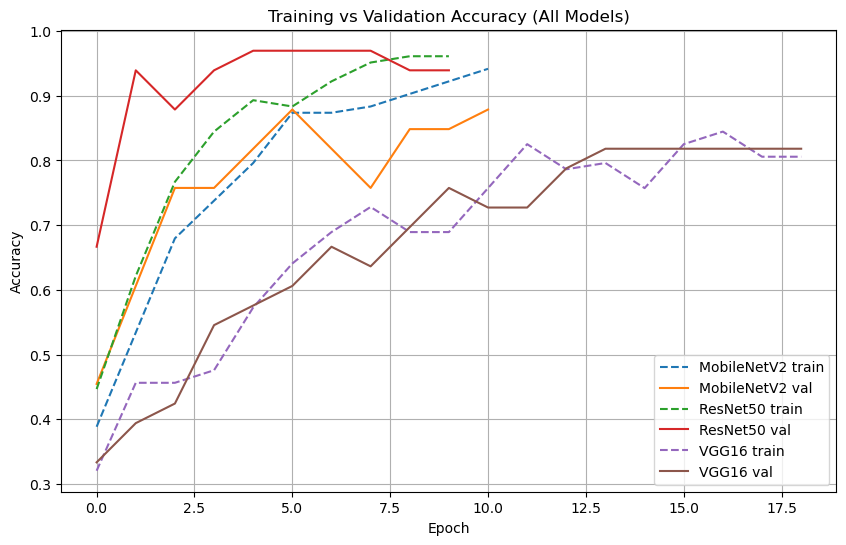

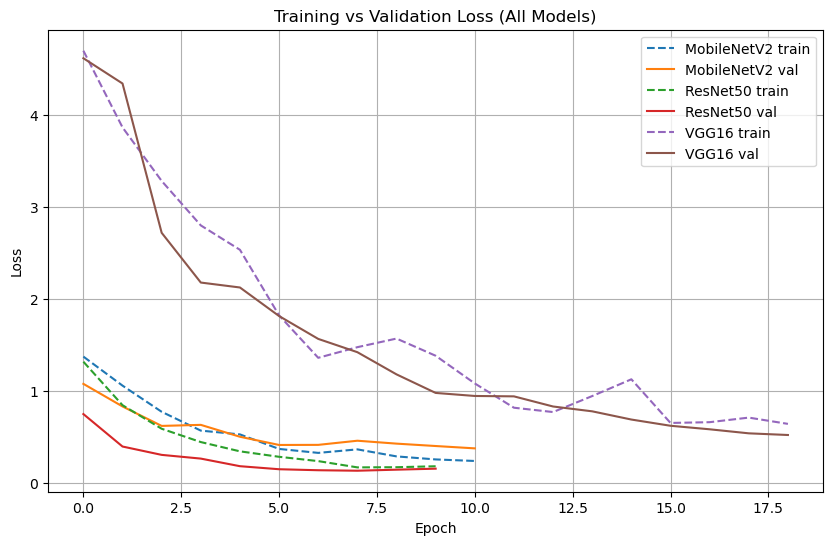

In [9]:
# Cell 8 — Compact comparison version (only 2 plots total)

plt.figure(figsize=(10,6))
for name, hist in histories.items():
    plt.plot(hist.history["accuracy"], linestyle="--", label=f"{name} train")
    plt.plot(hist.history["val_accuracy"], label=f"{name} val")

plt.title("Training vs Validation Accuracy (All Models)")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.grid(True)
plt.show()


plt.figure(figsize=(10,6))
for name, hist in histories.items():
    plt.plot(hist.history["loss"], linestyle="--", label=f"{name} train")
    plt.plot(hist.history["val_loss"], label=f"{name} val")

plt.title("Training vs Validation Loss (All Models)")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)
plt.show()

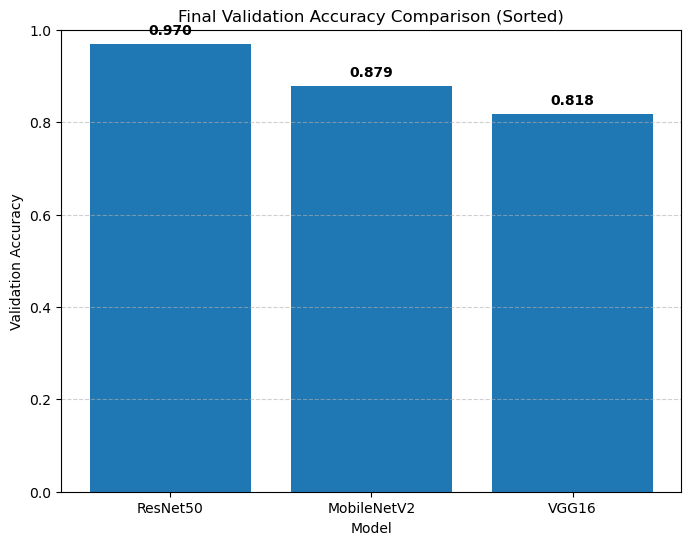

In [10]:
# Sort by validation accuracy (highest first)
df_sorted = df_results.sort_values("val_accuracy", ascending=False)

plt.figure(figsize=(8,6))
bars = plt.bar(df_sorted["model"], df_sorted["val_accuracy"])

plt.title("Final Validation Accuracy Comparison (Sorted)")
plt.xlabel("Model")
plt.ylabel("Validation Accuracy")
plt.ylim(0, 1)

for i, v in enumerate(df_sorted["val_accuracy"]):
    plt.text(i, v + 0.02, f"{v:.3f}", ha='center', fontweight='bold')

plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.show()

Found 103 images belonging to 3 classes.
Found 33 images belonging to 3 classes.
3/3 ━━━━━━━━━━━━━━━━━━━━ 5s 1s/step  


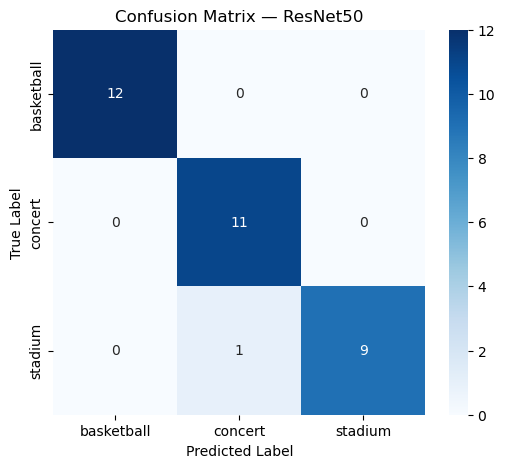

In [11]:
# Cell 10 — Confusion Matrix for the best model (ResNet50)

from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Use validation generator again (NO shuffle!)
_, val_gen = make_generators(resnet_preprocess)

# Get predictions
pred_probs = models_dict["ResNet50"].predict(val_gen)
pred_classes = np.argmax(pred_probs, axis=1)

# True labels
true_classes = val_gen.classes

# Class names (folder names)
class_names = list(val_gen.class_indices.keys())

# Compute confusion matrix
cm = confusion_matrix(true_classes, pred_classes)

# Plot
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=class_names,
            yticklabels=class_names)

plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix — ResNet50")
plt.show()

3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 473ms/step


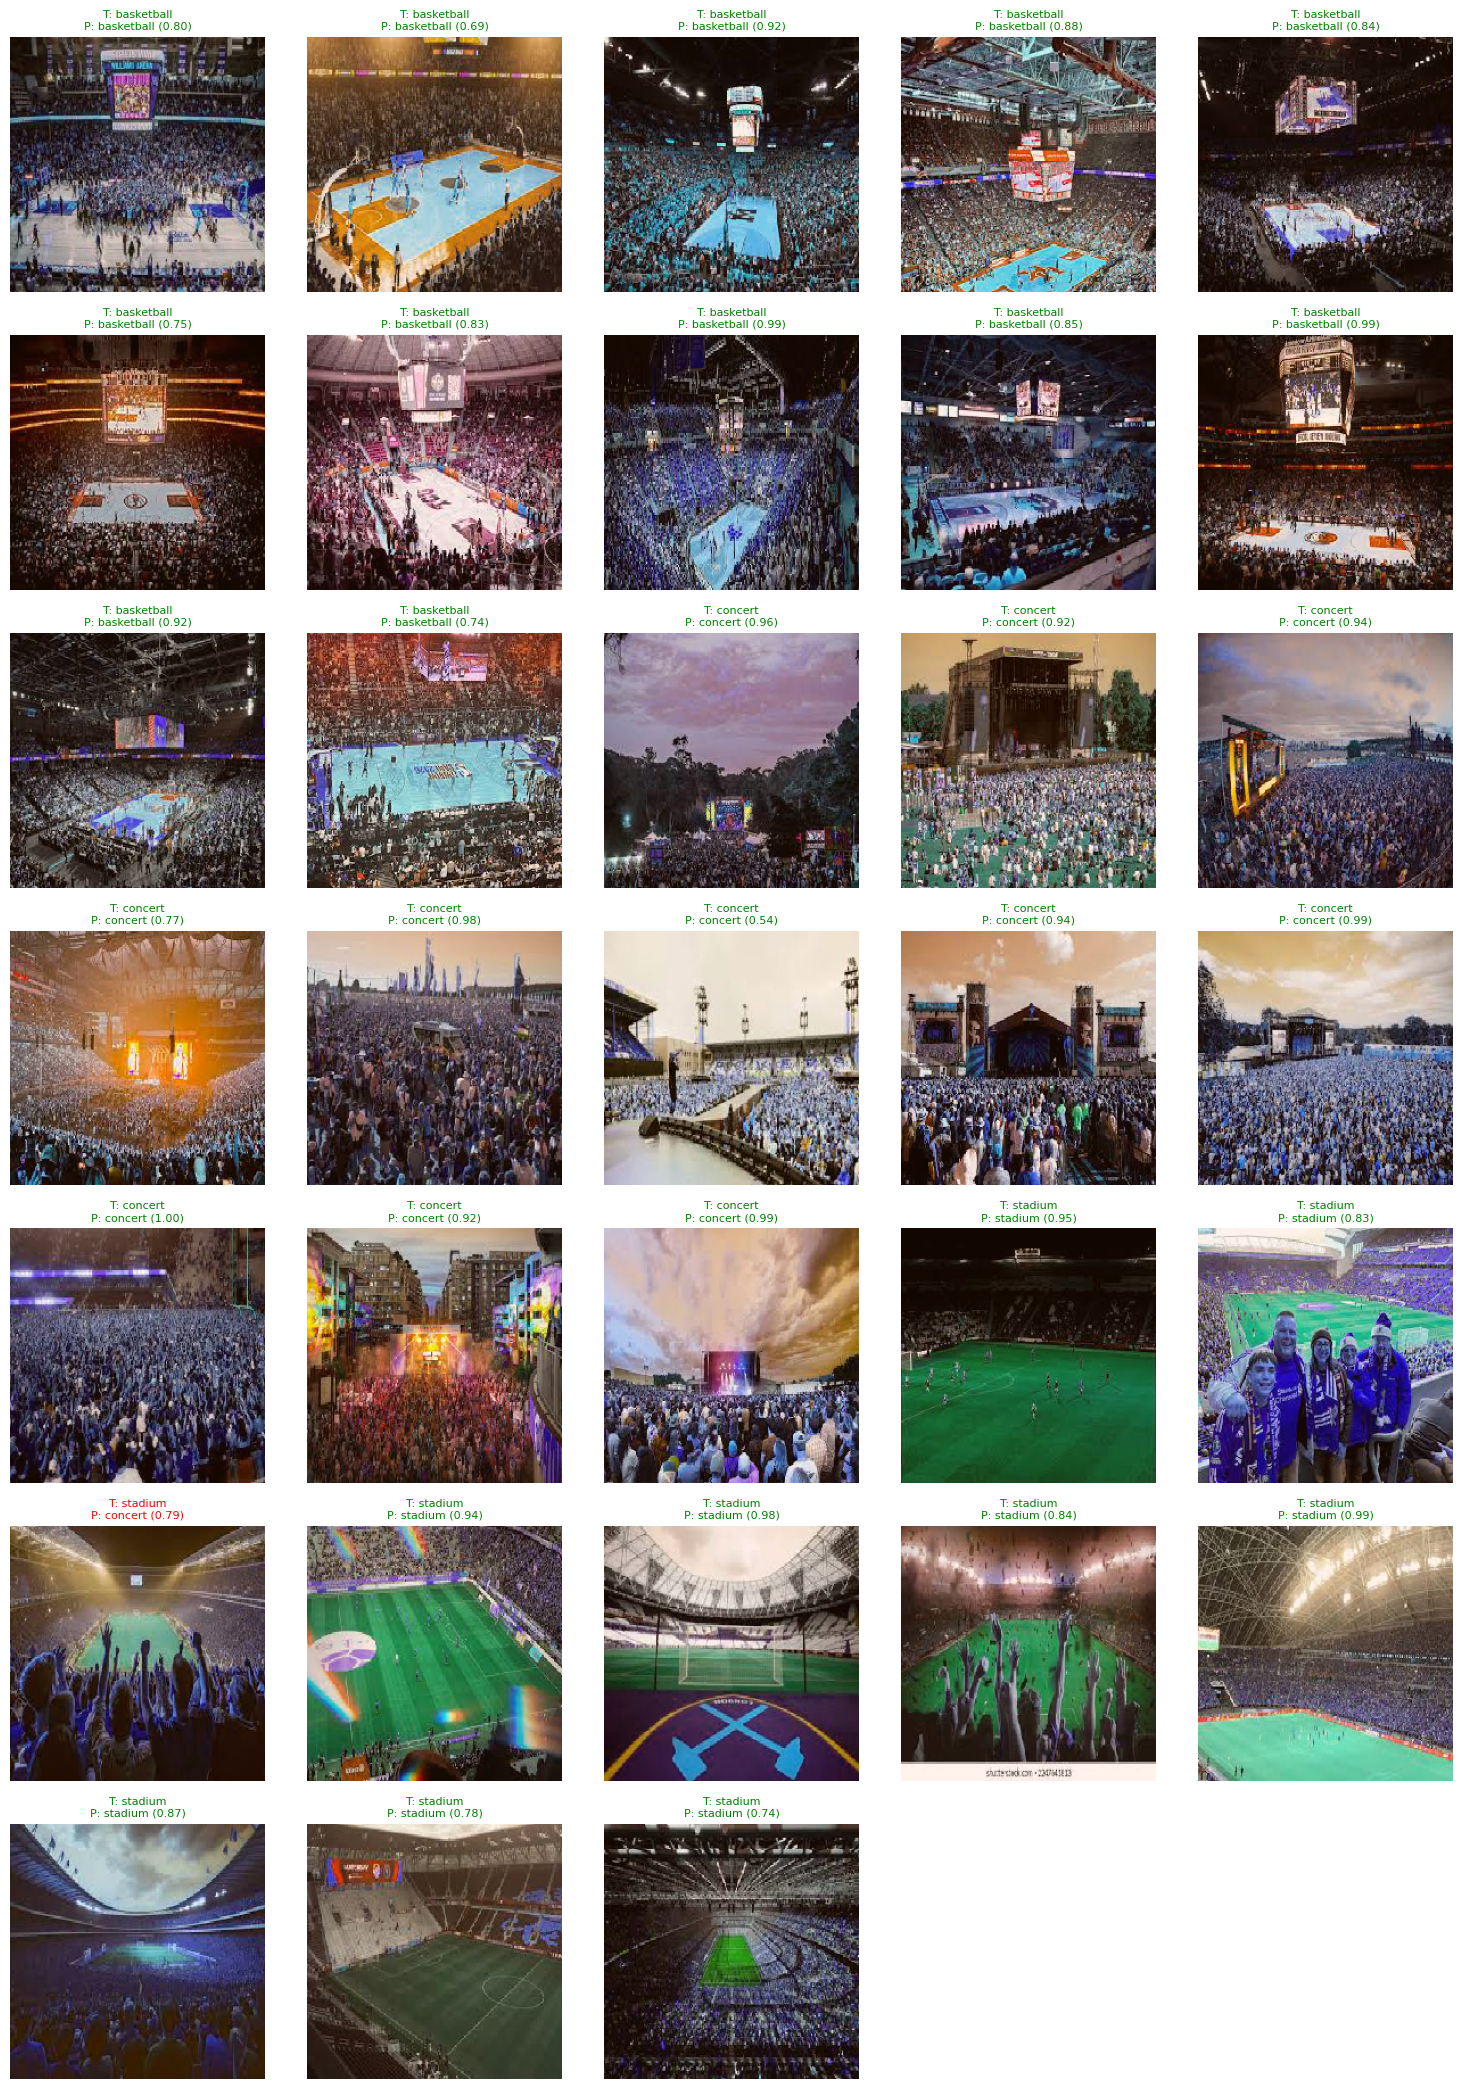

In [12]:
# Cell 12 — Display ALL validation images with predictions (full inspection)

import matplotlib.pyplot as plt
import numpy as np
import math

# Reset generator
val_gen.reset()

# Predict on entire validation set
pred_probs = models_dict["ResNet50"].predict(val_gen)
pred_classes = np.argmax(pred_probs, axis=1)
true_classes = val_gen.classes

class_names = list(val_gen.class_indices.keys())

# Load ALL validation images in order
val_gen.reset()
images_all = []
labels_all = []

for i in range(len(val_gen)):
    imgs, lbls = val_gen[i]
    images_all.append(imgs)
    labels_all.append(lbls)

images_all = np.vstack(images_all)
labels_all = np.vstack(labels_all)
true_classes = np.argmax(labels_all, axis=1)

num_images = len(images_all)

# Grid size automatically determined
cols = 5
rows = math.ceil(num_images / cols)

plt.figure(figsize=(15, rows * 3))

for i in range(num_images):
    plt.subplot(rows, cols, i + 1)

    img = images_all[i]

    # Normalize image for display
    img = img - img.min()
    img = img / img.max()

    plt.imshow(img)

    true_label = class_names[true_classes[i]]
    pred_label = class_names[pred_classes[i]]
    confidence = np.max(pred_probs[i])

    color = "green" if true_label == pred_label else "red"

    plt.title(f"T: {true_label}\nP: {pred_label} ({confidence:.2f})",
              color=color, fontsize=8)

    plt.axis("off")

plt.tight_layout()
plt.show()


In [13]:
# Cell 1 — Quick setup for Task 4-2 (paths + constants)
import os, numpy as np, tensorflow as tf

DATASET_DIR = "dataset"
TRAIN_DIR = os.path.join(DATASET_DIR, "train")
VAL_DIR   = os.path.join(DATASET_DIR, "validation")

IMG_SIZE = (224, 224)
BATCH_SIZE = 16
SEED = 42

tf.random.set_seed(SEED)
np.random.seed(SEED)

NUM_CLASSES = len(os.listdir(TRAIN_DIR))
print("Classes:", os.listdir(TRAIN_DIR))
print("NUM_CLASSES:", NUM_CLASSES)

Classes: ['basketball', 'concert', 'stadium']
NUM_CLASSES: 3


In [14]:
# Cell 2 — Data generators (model-specific preprocessing + small-data augmentation)
from tensorflow.keras.preprocessing.image import ImageDataGenerator

def make_generators(preprocess_fn):
    # Training augmentation 
    train_datagen = ImageDataGenerator(
        preprocessing_function=preprocess_fn,
        rotation_range=15,
        width_shift_range=0.10,
        height_shift_range=0.10,
        zoom_range=0.15,
        horizontal_flip=True
    )

    # Validation: only preprocessing
    val_datagen = ImageDataGenerator(
        preprocessing_function=preprocess_fn
    )

    train_gen = train_datagen.flow_from_directory(
        TRAIN_DIR,
        target_size=IMG_SIZE,
        batch_size=BATCH_SIZE,
        class_mode="categorical",
        shuffle=True,
        seed=SEED
    )

    val_gen = val_datagen.flow_from_directory(
        VAL_DIR,
        target_size=IMG_SIZE,
        batch_size=BATCH_SIZE,
        class_mode="categorical",
        shuffle=False
    )

    return train_gen, val_gen

In [15]:
# Cell 3 — A helper to build the model + choose frozen vs fine-tune
from tensorflow.keras import layers, models

def build_model(base_model, num_classes, fine_tune=False, unfreeze_last_n=20, lr=1e-3):
    """
    fine_tune=False: freeze whole base model (feature extraction)
    fine_tune=True : unfreeze last N layers and train with low LR
    """
    # 1) Start by freezing everything
    base_model.trainable = False

    # 2) If fine-tuning, unfreeze only the last N layers
    if fine_tune:
        for layer in base_model.layers[-unfreeze_last_n:]:
            layer.trainable = True

    # 3) Build classifier head
    inputs = layers.Input(shape=(IMG_SIZE[0], IMG_SIZE[1], 3))
    x = base_model(inputs, training=False)  # keep BatchNorm stable
    x = layers.Dropout(0.2)(x)
    outputs = layers.Dense(num_classes, activation="softmax")(x)

    model = models.Model(inputs, outputs)

    # 4) Compile 
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=lr),
        loss="categorical_crossentropy",
        metrics=["accuracy"]
    )
    return model

In [16]:
# Cell 4 — Select 3 Keras Applications models
from tensorflow.keras.applications import MobileNetV2, ResNet50, VGG16
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input as mobilenet_preprocess
from tensorflow.keras.applications.resnet50 import preprocess_input as resnet_preprocess
from tensorflow.keras.applications.vgg16 import preprocess_input as vgg_preprocess

MODEL_SPECS = [
    {
        "name": "MobileNetV2",
        "builder": lambda: MobileNetV2(weights="imagenet", include_top=False, pooling="avg", input_shape=(224,224,3)),
        "preprocess": mobilenet_preprocess
    },
    {
        "name": "ResNet50",
        "builder": lambda: ResNet50(weights="imagenet", include_top=False, pooling="avg", input_shape=(224,224,3)),
        "preprocess": resnet_preprocess
    },
    {
        "name": "VGG16",
        "builder": lambda: VGG16(weights="imagenet", include_top=False, pooling="avg", input_shape=(224,224,3)),
        "preprocess": vgg_preprocess
    }
]

In [17]:
# Cell 5 — Train each model twice: Frozen vs Fine-tuned (last 20 layers)
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import pandas as pd

results_42 = []

for spec in MODEL_SPECS:
    name = spec["name"]
    print("\n" + "="*70)
    print(f"Model: {name}")
    print("="*70)

    train_gen, val_gen = make_generators(spec["preprocess"])

    # ----- Run A: Frozen base -----
    print("\n--> Run A: Frozen base (feature extraction)")
    base_A = spec["builder"]()
    model_A = build_model(base_A, NUM_CLASSES, fine_tune=False, lr=1e-3)

    callbacks_A = [
        EarlyStopping(monitor="val_accuracy", patience=5, restore_best_weights=True),
        ReduceLROnPlateau(monitor="val_loss", patience=2, factor=0.3, min_lr=1e-6)
    ]

    hist_A = model_A.fit(
        train_gen,
        validation_data=val_gen,
        epochs=15,
        callbacks=callbacks_A,
        verbose=1
    )

    val_loss_A, val_acc_A = model_A.evaluate(val_gen, verbose=0)
    results_42.append({
        "Model": name,
        "Setting": "Frozen base",
        "Val_Accuracy": float(val_acc_A),
        "Val_Loss": float(val_loss_A)
    })

    # ----- Run B: Fine-tune last 20 layers -----
    print("\n--> Run B: Fine-tune last 20 layers (low LR)")
    base_B = spec["builder"]()
    model_B = build_model(base_B, NUM_CLASSES, fine_tune=True, unfreeze_last_n=20, lr=1e-5)

    callbacks_B = [
        EarlyStopping(monitor="val_accuracy", patience=5, restore_best_weights=True),
        ReduceLROnPlateau(monitor="val_loss", patience=2, factor=0.3, min_lr=1e-7)
    ]

    hist_B = model_B.fit(
        train_gen,
        validation_data=val_gen,
        epochs=15,
        callbacks=callbacks_B,
        verbose=1
    )

    val_loss_B, val_acc_B = model_B.evaluate(val_gen, verbose=0)
    results_42.append({
        "Model": name,
        "Setting": "Fine-tune last 20",
        "Val_Accuracy": float(val_acc_B),
        "Val_Loss": float(val_loss_B)
    })

df_42 = pd.DataFrame(results_42)
df_42


Model: MobileNetV2
Found 103 images belonging to 3 classes.
Found 33 images belonging to 3 classes.

--> Run A: Frozen base (feature extraction)
Epoch 1/15
7/7 ━━━━━━━━━━━━━━━━━━━━ 9s 734ms/step - accuracy: 0.4272 - loss: 1.3610 - val_accuracy: 0.3636 - val_loss: 1.1206 - learning_rate: 0.0010
Epoch 2/15
7/7 ━━━━━━━━━━━━━━━━━━━━ 3s 483ms/step - accuracy: 0.5049 - loss: 1.0262 - val_accuracy: 0.6061 - val_loss: 0.8503 - learning_rate: 0.0010
Epoch 3/15
7/7 ━━━━━━━━━━━━━━━━━━━━ 4s 521ms/step - accuracy: 0.6602 - loss: 0.6426 - val_accuracy: 0.7576 - val_loss: 0.6600 - learning_rate: 0.0010
Epoch 4/15
7/7 ━━━━━━━━━━━━━━━━━━━━ 3s 498ms/step - accuracy: 0.7573 - loss: 0.5822 - val_accuracy: 0.8182 - val_loss: 0.5357 - learning_rate: 0.0010
Epoch 5/15
7/7 ━━━━━━━━━━━━━━━━━━━━ 3s 481ms/step - accuracy: 0.8447 - loss: 0.4328 - val_accuracy: 0.8485 - val_loss: 0.4908 - learning_rate: 0.0010
Epoch 6/15
7/7 ━━━━━━━━━━━━━━━━━━━━ 3s 474ms/step - accuracy: 0.8447 - loss: 0.4040 - val_accuracy: 0.81

Model            Setting  Val_Accuracy  Val_Loss
0  MobileNetV2        Frozen base      0.848485  0.490755
1  MobileNetV2  Fine-tune last 20      0.575758  0.899622
2     ResNet50        Frozen base      0.939394  0.288865
3     ResNet50  Fine-tune last 20      0.636364  0.713697
4        VGG16        Frozen base      0.848485  0.895573
5        VGG16  Fine-tune last 20      0.878788  0.559423

In [18]:
# Cell 6 — results table 
df_pivot = df_42.pivot(index="Model", columns="Setting", values="Val_Accuracy")
df_pivot

Setting      Fine-tune last 20  Frozen base
Model                                      
MobileNetV2           0.575758     0.848485
ResNet50              0.636364     0.939394
VGG16                 0.878788     0.848485

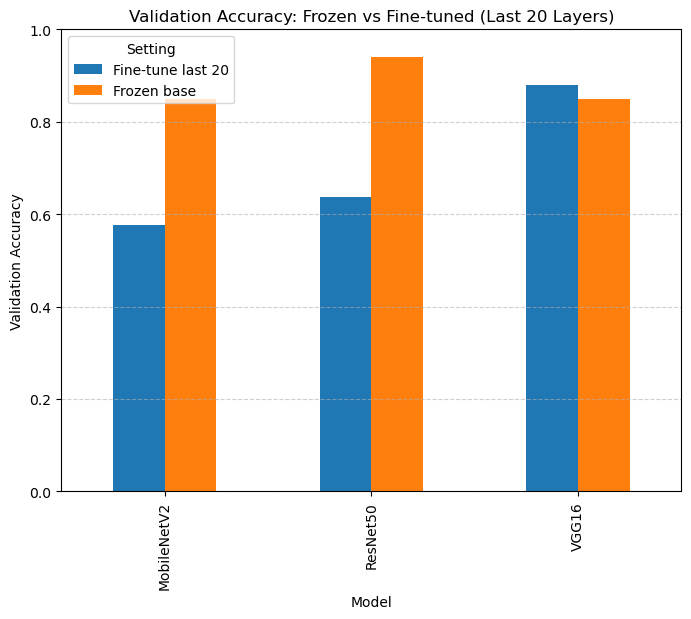

In [19]:
# Cell 7 — bar chart to visualize Frozen vs Fine-tuned per model
import matplotlib.pyplot as plt

pivot_plot = df_42.pivot(index="Model", columns="Setting", values="Val_Accuracy")

pivot_plot.plot(kind="bar", figsize=(8,6))
plt.title("Validation Accuracy: Frozen vs Fine-tuned (Last 20 Layers)")
plt.xlabel("Model")
plt.ylabel("Validation Accuracy")
plt.ylim(0, 1)
plt.grid(axis="y", linestyle="--", alpha=0.6)
plt.show()

In [20]:
# Cell — Comparison table 

df_compare = df_42.pivot(index="Model", columns="Setting", values="Val_Accuracy")

df_compare = df_compare.rename(columns={
    "Frozen base": "Frozen",
    "Fine-tune last 20": "Fine-tune"
})

df_compare["Δ (Fine - Frozen)"] = df_compare["Fine-tune"] - df_compare["Frozen"]

df_compare = df_compare.round(3)

df_compare

Setting      Fine-tune  Frozen  Δ (Fine - Frozen)
Model                                            
MobileNetV2      0.576   0.848             -0.273
ResNet50         0.636   0.939             -0.303
VGG16            0.879   0.848              0.030